### Este Script permite realizar un primer análisis de los datos paleoclimáticos de Polvo y Temperatura.
##### Comenzamos por importar las librerias necesarias y los datos necesarios

In [21]:
# ** CHEQUEAR QUÉ LIBRERIAS ESTOY Y NO ESTOY USANDO** 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtpl
#pip install plotly
import plotly.express as px

from scipy import stats

from scipy import signal
from sklearn.linear_model import LinearRegression


In [2]:
dust_file='Dust records corregidos 23-05-22.xlsx'
#temp_file='Temps records corregidos 23-05-22.xlsx'
temp_file='Temps records corregidos con Sambao.xlsx'


Importamos los datos de identificación de cada Proxy

In [30]:
id_columns=['Name','Data id','Latitud','Longitud','Age units','Data units','Data length']

#id_data=pd.read_excel(dust_file,sheet_name=0,usecols=id_columns)
id_data=pd.read_excel(temp_file,sheet_name=0,usecols=id_columns)

id_data.head()

,Name,Data id,Latitud,Longitud,Age units,Data units,Data length
0,Siple Dome,1,-81.65,-149.01,Not Specified,Not Specified,1879
1,WAIS Divide Core,2,-79.47,-112.09,ka 1950,per mil,6375
2,Vostok,3,-78.46,106.87,ka,Not Specified,507
3,Dome Fuji Ice Core,4,-77.5,37.5,Ky B2k,per mil,679
4,Epica Dome C,5,-75.1,123.35,kaBP,°K,5787


Importamos los valores (Dust/Temp u equivalente) de cada proxy

In [31]:
#df_data=pd.read_excel(dust_file,sheet_name=1,skiprows=1)
df_data=pd.read_excel(temp_file,sheet_name=1,skiprows=1)

df_data.head()

,Year,dB,Year.1,d18O,Year.2,deut,Year.3,delta-T,Year.4,Temp,...,Year.7,d18O.2,Year.8,d18O,Year.9,Temp.2,Year.10,Temp.3,Year.11,Temp.4
0,-0.045,-229.81,-0.056900,-32.3263,4.509,-431.20,0.5,0.4,0.03539,218.4,...,-0.017,-9.50,0.02,-35.16,6.5,0.133170,6.5,0.236032,6.5,-0.029036
1,-0.044,-205.73,-0.054285,-34.9809,4.552,-432.70,1.0,0.8,0.04405,219.4,...,0.000,-9.66,0.04,-35.82,6.6,0.138927,6.6,0.237451,6.6,-0.016437
2,-0.042,-193.52,-0.052178,-34.2941,4.690,-443.30,1.5,-0.2,0.05272,220.6,...,0.020,-9.58,0.06,-35.11,6.7,0.143500,6.7,0.247552,6.7,-0.020581
3,-0.040,-198.51,-0.050028,-32.9244,5.259,-436.30,2.0,-0.8,0.06171,217.9,...,0.038,-9.50,0.08,-34.65,6.8,0.161308,6.8,0.274253,6.8,-0.016798
4,-0.038,-195.76,-0.047870,-34.9492,5.674,-438.37,2.5,-0.4,0.07104,217.1,...,0.056,-9.33,0.10,-34.53,6.9,0.159509,6.9,0.272957,6.9,-0.019388


#### Comenzamos el pretratamiento de datos:
Lo primero será separar el gran Dataframe en N distintos dataframes del tipo [Year, Value]. 

Reviso primero la cantidad de Nan's que hay por intervalos (ventanas w)

Separo cada una de las columnas en grupos de 2 (agrupados por proxy)

Para cada sub-DF se eliminaran los valores Nan's.

In [32]:
#SEPARAR CADA UNA DE LAS COLUMNAS v.2
columns=df_data.size/len(df_data) #data.size = nxm ; len(data) = n -> cuociente = m = n°columnas
lis=[] #Lista de dupla de dataframes: Age & Values
new_length=np.array([])

for i in range(int(columns)):
    if (i+1)%2==1: #División completa, voy de 2 en 2
        dupla=df_data[[df_data.columns[i],df_data.columns[i+1]]].dropna() #Elimino los Nan de cada columna (age & dust/temp)
        dupla.index=[j for j in range(0, len(dupla))] #Reset de los índices de la serie
        lis.append(dupla)
        new_length=np.append(new_length,np.shape(dupla)[0])

In [33]:
# ** Chequeo la separación de datos **
# Largo de cada data [año , valor]
#new_length es el número de valores no vacios

dif_length=pd.Series(id_data['Data length']-new_length)
original_length=id_data['Data length']
prop_length=pd.Series(dif_length/original_length*100)
len_df=pd.concat([original_length,dif_length,prop_length], axis=1)
len_df.columns = ['Original Len','Deleted','% deleted']
len_df.index=id_data['Name']

len_df

,Original Len,Deleted,% deleted
Name,,,
Siple Dome,1879,0.0,0.000000
WAIS Divide Core,6375,2.0,0.031373
Vostok,507,0.0,0.000000
Dome Fuji Ice Core,679,0.0,0.000000
Epica Dome C,5787,0.0,0.000000
"Sajama ice core, Bolivia",251,0.0,0.000000
Lake Tanganyika,209,0.0,0.000000
Sanbao and Dongge Cave,6111,0.0,0.000000
NGRIP,6114,0.0,0.000000


Revisamos cuantos datos han sido eliminados

#### Pasamos ahora al análisis de los datos

Primero vemos la descripción simple de los datos como Dataframes y su ubicación geográfica

In [16]:
# ** DESCRIBE**
#*** DF con basic description ***
pd.set_option('display.float_format', lambda x: '%.3f' % x)
for i in range(len(lis)):
    if i==0:
        description=lis[i].describe()
    else:
        description=pd.concat([description,lis[i].describe()], axis=1)
 
Dust_name='Dust Description.xlsx'
Temp_name='Temp Description.xlsx'
#description.to_excel(Temp_name) 

description

,Year,dB,Year.1,d18O,Year.2,deut,Year.3,delta-T,Year.4,Temp,...,Year.7,d18O.2,Year.8,d18O,Year.9,Temp.2,Year.10,Temp.3,Year.11,Temp.4
count,1879.000,1879.000,6373.000,6373.000,507.000,507.000,679.000,679.000,5787.000,5787.000,...,6111.000,6111.000,6114.000,6114.000,156.000,156.000,156.000,156.000,156.000,156.000
mean,14.851,-226.658,17.346,-36.163,168.818,-461.001,170.000,-4.200,191.045,213.625,...,209.576,-8.794,61.150,-39.942,14.250,-1.808,14.250,-1.975,14.250,-1.544
std,18.312,24.204,16.828,3.125,101.503,15.628,98.077,2.927,192.703,3.126,...,187.354,1.161,35.302,2.968,4.518,1.445,4.518,1.532,4.518,1.362
min,-0.045,-292.670,-0.057,-43.130,4.509,-485.700,0.500,-9.500,0.035,208.100,...,-0.017,-11.580,0.020,-46.500,6.500,-3.583,6.500,-3.657,6.500,-3.481
25%,2.316,-248.180,4.774,-39.246,96.826,-473.750,85.250,-6.600,46.691,211.100,...,45.650,-9.720,30.585,-42.370,10.375,-3.312,10.375,-3.456,10.375,-3.016
50%,6.996,-216.470,10.830,-34.901,149.679,-464.200,170.000,-4.500,121.419,213.100,...,147.000,-8.850,61.150,-39.880,14.250,-1.698,14.250,-2.120,14.250,-1.407
75%,19.676,-209.270,25.944,-33.474,235.197,-449.550,254.750,-2.300,274.748,216.200,...,364.850,-7.937,91.715,-37.883,18.125,-0.100,18.125,-0.232,18.125,-0.075
max,94.489,-182.250,67.695,-30.302,422.135,-416.200,339.500,4.200,801.076,223.300,...,641.300,-2.890,122.280,-32.110,22.000,0.177,22.000,0.320,22.000,0.139


In [26]:
coor_columns=['Name','Latitud','Longitud','Proxy']
coor_data=pd.read_excel('Coordenadas.xlsx',sheet_name=0,usecols=coor_columns)

coordenadas = coor_data[['Latitud','Longitud','Proxy']]
fig = px.scatter_geo(coordenadas,lat='Latitud',lon='Longitud', hover_name=coor_data['Name'],color='Proxy')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=0.89,
    xanchor="left",
    x=-0.1
))
fig.update_layout(title = 'Global Proxies Distribution', title_x=0.5)
#fig.savefig('global proxies distribution.pdf', bbox_inches='tight')
fig.write_image("2-Proxies Global Distribution.pdf")
#fig.write_image("fig1.png")
fig.show()

In [45]:
#No se puede guardar tan fácilmente la imágen
#Ver si puedo plotear Dust & Temp!

#df = id_data[['Latitud','Longitud']]
#fig = px.scatter_geo(df,lat='Latitud',lon='Longitud', hover_name=id_data['Name'],color_discrete_sequence=["red"])
#fig.update_layout(title = 'Global Proxies map', title_x=0.5)

#fig.show()

Creamos una función para ver las diferencias de resolución de los datos

In [27]:
## ACA ELIJO CON CUAL PROXY VOY A TRABAJAR
n=0
original_age=lis[n][lis[n].columns[0]]
original_values=lis[n][lis[n].columns[1]]

In [8]:
## Ojo, uso original_age(que defino despues) -> age ... producirá un bug?
def interpolation(age,values,bottom_resolution):
    x = np.array(age)
    y = np.array(values)
    new_points=(original_age.max()-original_age.min())/bottom_resolution*1000 ##ACA USO ORIGINAL AGE
    f2=interp1d(x, y, kind='linear')
    xnew = np.linspace(x.min(), x.max(), num=int(new_points), endpoint=True)
    return xnew,f2(xnew)

def diff(age):
    differences=age[1:]-age[:-1]
    differences = pd.DataFrame(differences)*1000
    return differences

#### Acá saco las resoluciones de fondo y superficie. Pasar a un DF para luego mostrarlo ordenado.
##### Guardar las imágenes también?

Top resolution  200    bottom resolution:  405


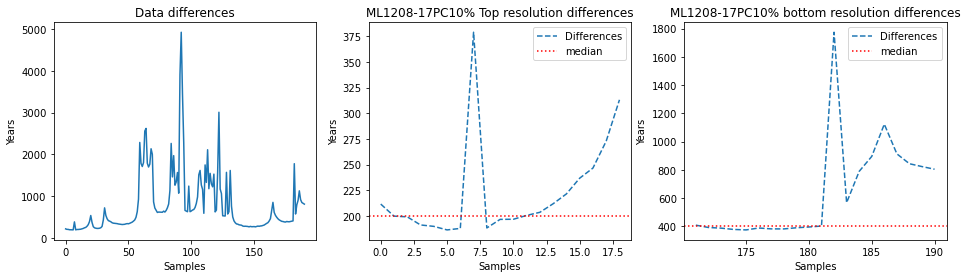

In [15]:
## ACA ELIJO CON CUAL PROXY VOY A TRABAJAR
n=5
original_age=lis[n][lis[n].columns[0]]
original_values=lis[n][lis[n].columns[1]]

#Calculo la resolución promedio del 10% superior y 10% inferior
diferencias=diff(np.array(original_age))
samples=len(diferencias)
top_index=int(samples*0.1)
bottom_index=int(samples-samples*0.1)
top_resolution=int(diferencias[:top_index].median())
bottom_resolution=int(diferencias[bottom_index:].median())

fig, ax = plt.subplots(1,3)
fig.set_figwidth(16)
ax[0].plot(diferencias,'-')
title1='Data differences'
ax[0].set_title(title1)
ax[0].set_xlabel('Samples')
ax[0].set_ylabel('Years')

ax[1].plot(diferencias[:top_index],'--',label='Differences')
ax[1].axhline(y = top_resolution, color = 'r', linestyle = ':',label='median')
title2=id_data['Name'][n]+'10% Top resolution differences'
ax[1].set_title(title2)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Years')
ax[1].legend()

ax[2].plot(diferencias[bottom_index:],'--',label='Differences')
ax[2].axhline(y = bottom_resolution, color = 'r', linestyle = ':',label='median')
title3=id_data['Name'][n]+'10% bottom resolution differences'
ax[2].set_title(title3)
ax[2].set_xlabel('Samples')
ax[2].set_ylabel('Years')
ax[2].legend()

print('Top resolution ',top_resolution,'   bottom resolution: ',bottom_resolution)
plt.show()


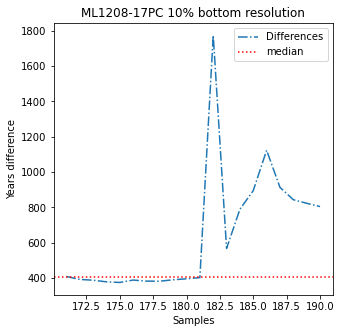

In [18]:
plt.subplots(figsize=(5,5))
plt.plot(diferencias[bottom_index:],'-.',label='Differences')
plt.axhline(y = bottom_resolution, color = 'r', linestyle = ':',label='median')
title3=id_data['Name'][n]+' 10% bottom resolution'
plt.title(title3)
plt.xlabel('Samples')
plt.ylabel('Years difference')
plt.legend()
plt.savefig('Bottom resolution'+id_data['Name'][n]+'.pdf', bbox_inches='tight')

plt.show()

### el DF de acá no lo quiero usar, no lo borraré solo por tiempo
#### Usarlo de guía para el DF anterior. Guardar la imágen de resolución normalizada

In [27]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}

mtpl.rc('font', **font)

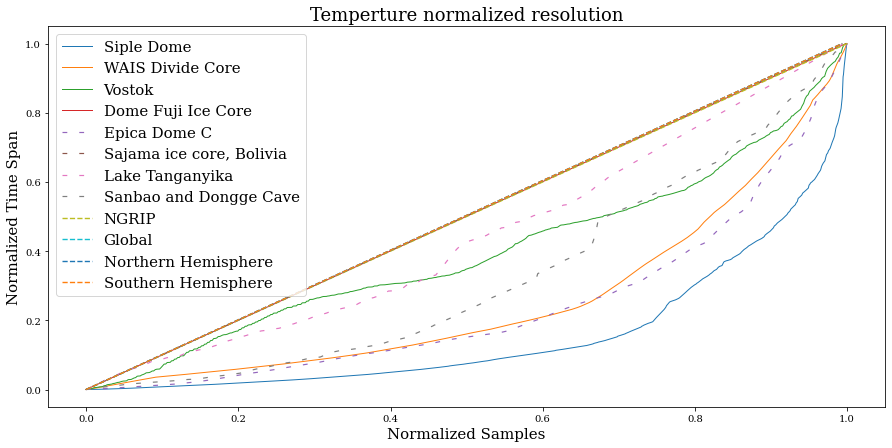

In [36]:
fig, ax =plt.subplots(1,1)
fig.set_figwidth(15)
fig.set_figheight(7)

res_df=[]
for i in range(len(lis)):
    difference=diff(np.array(lis[i][lis[i].columns[0]]))
    res_df.append([id_data['Name'][i],int(difference.mean()),int(difference.max())]) #para el DF
    
    
    x=[]
    for j in range(int(new_length[i])):#para el rango de largo de datos
        x.append(j/new_length[i]) #normalizo el número de muestras. 
    num=lis[i][lis[i].columns[0]]-lis[i][lis[i].columns[0]][0] #años del proxy i-año inicial
    denom=lis[i][lis[i].columns[0]].max()-lis[i][lis[i].columns[0]][0]#max año -año inicial
    
    if i<=3:
        ax.plot(x,num/denom,label=id_data['Name'][i],linewidth=1,linestyle='-',alpha=1)
    if i>3 and i<=7:
        ax.plot(x,num/denom,label=id_data['Name'][i],linewidth=1.2,linestyle=(0, (4,10)),alpha=1)
        
    if i>7:
        ax.plot(x,num/denom,label=id_data['Name'][i],linewidth=1.4,linestyle='--',alpha=1)
        
        
    ax.set_title('Temperture normalized resolution') #### DUST/ TEMPS
    #ax.set_title('Dust normalized resolution') #### DUST/ TEMPS
    ax.set_xlabel('Normalized Samples')
    ax.set_ylabel('Normalized Time Span')
    ax.legend(loc='upper left')
    
mtpl.rc('xtick', labelsize=10) 
mtpl.rc('ytick', labelsize=10)

#plt.savefig('Dust normalized resolution.pdf',bbox_inches='tight')
plt.savefig('Temps normalized resolution.pdf',bbox_inches='tight')


#df_resolution = pd.DataFrame(res_df)
#df_resolution.columns = ['Name','Mean resolution','Worst resolution']
#df_resolution.to_excel('Temp resolution.xlsx') 
#df_resolution

Se evalúa ahora los valores fuera de rango

In [29]:
#promedio movil
def moving_average(x, w):
    promedios=np.convolve(x, np.ones(w), 'same') / w    
    return x-promedios

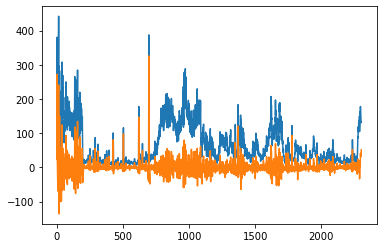

In [34]:
## veo cómo cambian los datos al quitarle el promedio movil
## ventana de 15 samples tomadas de forma arbitraria .... estará bien?
plt.plot(original_values)
plt.plot(moving_average(original_values,15))
plt.show()

In [36]:
# ** OUTLIERS **
# ***** LOS DATOS NO SON GAUSSIANOS, ESTA BIEN ESTIMAR LOS OULIERS DE ESTA MANERA? ****

#lis[i] = numero de dataframe
#lis[i].columns[0] = Age n
#lis[i].columns[1] = Dust n

q99=[]
for i in range(len(lis)):
    original_age=lis[i][lis[i].columns[0]]
    original_values=lis[i][lis[i].columns[1]]
    
    
    q=moving_average(original_values,15).quantile(0.99)
    q99.append(q)
    out=len(lis[i][lis[i].columns[1]])-np.count_nonzero(moving_average(original_values,15)<q)
    #print('N° of ouliers in ',id_data['Name'][i],':',out)
    print(out,' outliers out of ',len(lis[i][lis[i].columns[1]]),' in ',id_data['Name'][i])

24  outliers out of  2303  in  EPICA EDML
31  outliers out of  3038  in  GRIP
9  outliers out of  898  in  NGRIP
19  outliers out of  1801  in  Chinese Loess Plateau
24  outliers out of  2384  in  PS75/59-2
26  outliers out of  2560  in  PS75/76-2
8  outliers out of  722  in  Xifeng 
6  outliers out of  507  in  Vostok


Gráficamente se tiene lo siguiente

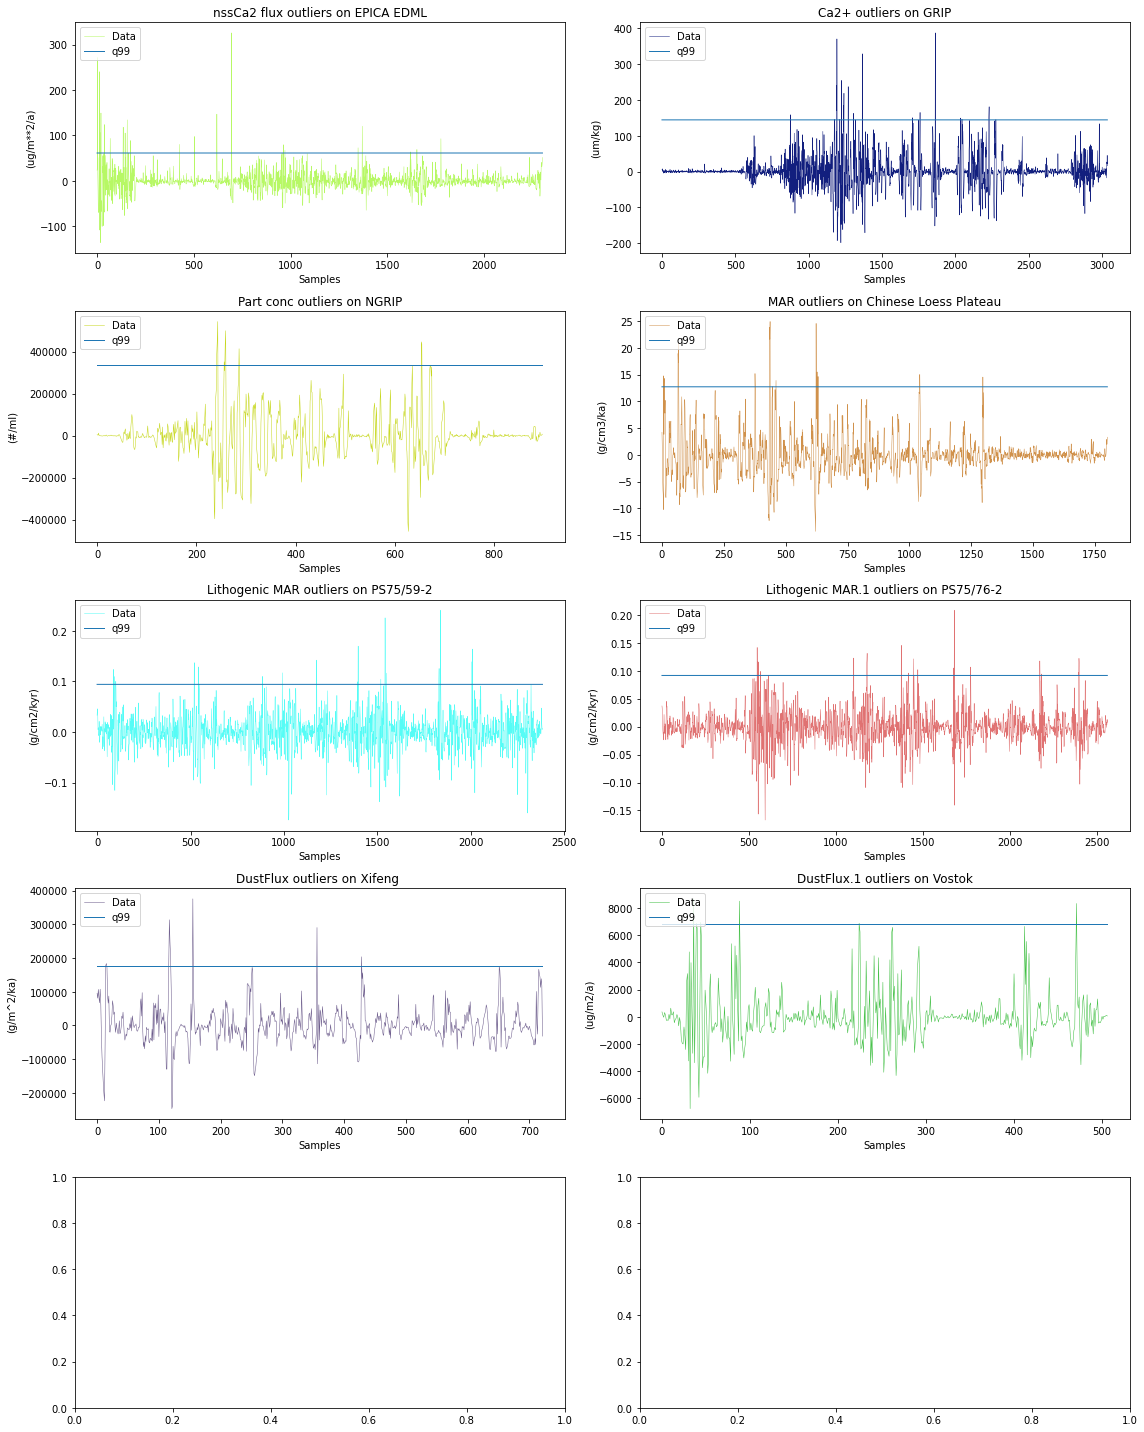

In [37]:
# ** Automatizar la creacion de subplots? **
fig, ax = plt.subplots(5,2)
fig.set_figwidth(16)
fig.set_figheight(20)

#Creo los 9 ejes X para los gráficos
outs=[]
ordeny=[0,1,0,1,0,1,0,1,0,1]
ordenx=[0,0,1,1,2,2,3,3,4,4,5,5]
for i in range(len(lis)):# 9
    original_age=lis[i][lis[i].columns[0]]
    original_values=lis[i][lis[i].columns[1]]
    
    out=[]
    x = range(0, len(lis[i])) #largo de data proxy i
    for datos in x:#para cada dato del proxy
        out.append(q99[i])
    outs.append(out)
    y = moving_average(original_values,15)
    ax[ordenx[i],ordeny[i]].plot(x,moving_average(original_values,15),label="Data",color=np.random.rand(3,),linewidth=0.5)
    ax[ordenx[i],ordeny[i]].plot(x,outs[i],label="q99",linewidth=1)
    ax[ordenx[i],ordeny[i]].legend(loc='upper left')
    ax[ordenx[i],ordeny[i]].set_xlabel('Samples')
    ax[ordenx[i],ordeny[i]].set_ylabel(id_data['Data units'][i])
    title=lis[i].columns[1]+' outliers on '+id_data['Name'][i]
    ax[ordenx[i],ordeny[i]].set_title(title)    
fig.tight_layout()   

#plt.savefig('Dust outliers.pdf')
#plt.savefig('Temps outliers.pdf')

plt.show()